In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from multiprocessing import Pool
import sys
import itertools

In [2]:
molecule_list = {
    "0" : "null",
    "1" : "acetonitrile",
    "2" : "ammonia",
    "3" : "carbonyl",
    "4" : "chloropyridine",
    "5" : "hydroisocyanide",
    "6" : "imidazole",
    "7" : "nme3",
    "8" : "ome2",
    "9" : "phosphine",
    "10" : "pf3",
    "11" : "thiophene",
    "12" : "thiopyridine",
    "13" : "water"
}

In [3]:
file_path = 'C:/Users/aditi/Documents/Trinity/Study/Research Project/ligands/D_values.txt'
ligands_source = {}
with open(file_path) as file:
    for line in file:
        key, value = line.rstrip().split(' ', 1)
        ligands_source[key] = value

In [4]:
ligand_rewards = {}
ligand_hash = {}

def reset_ligand_data():
    hash_counter = 0

    for ligand in ligands_source:
        structure = ligand.split('_')
        i=0
        converted_structure = []
        while i < len(structure):
            molecule_key = list(molecule_list.keys())[list(molecule_list.values()).index(structure[i])]
            occurence = int(structure[i+1])
            for k in range(occurence):
                converted_structure.append(int(molecule_key))
            i += 2
        ligand_hash[hash_counter] = converted_structure
        ligand_rewards[hash_counter] = -float(ligands_source[ligand])
        hash_counter += 1
        
    return

reset_ligand_data()
#print(ligand_rewards)
print(ligand_hash)

{0: [1, 1, 1, 1], 1: [2, 2, 2, 2], 2: [3, 3, 3, 3], 3: [4, 4, 4, 4], 4: [5, 5, 5, 5], 5: [6, 6, 6, 6], 6: [7, 7, 7, 7], 7: [8, 8, 8, 8], 8: [9, 9, 9, 9], 9: [11, 11, 11, 11], 10: [12, 12, 12, 12], 11: [13, 13, 13, 13], 12: [1, 1, 3, 3], 13: [2, 2, 1, 1], 14: [2, 2, 3, 3], 15: [2, 2, 8, 8], 16: [2, 2, 9, 9], 17: [4, 4, 1, 1], 18: [4, 4, 2, 2], 19: [4, 4, 5, 5], 20: [4, 4, 6, 6], 21: [4, 4, 7, 7], 22: [4, 4, 8, 8], 23: [4, 4, 10, 10], 24: [4, 4, 9, 9], 25: [4, 4, 11, 11], 26: [4, 4, 12, 12], 27: [4, 4, 13, 13], 28: [5, 5, 1, 1], 29: [5, 5, 2, 2], 30: [5, 5, 3, 3], 31: [5, 5, 6, 6], 32: [5, 5, 8, 8], 33: [5, 5, 13, 13], 34: [6, 6, 1, 1], 35: [6, 6, 2, 2], 36: [6, 6, 3, 3], 37: [6, 6, 8, 8], 38: [6, 6, 9, 9], 39: [6, 6, 13, 13], 40: [7, 7, 1, 1], 41: [7, 7, 2, 2], 42: [7, 7, 5, 5], 43: [7, 7, 6, 6], 44: [7, 7, 8, 8], 45: [7, 7, 9, 9], 46: [7, 7, 13, 13], 47: [8, 8, 1, 1], 48: [8, 8, 3, 3], 49: [8, 8, 9, 9], 50: [10, 10, 1, 1], 51: [10, 10, 2, 2], 52: [10, 10, 3, 3], 53: [10, 10, 6, 6], 54:

In [5]:
# Define a function to return hash of a state
def get_hash(state):
    state_permutations = itertools.permutations(state)
    val_list = list(ligand_hash.values())

    for n in state_permutations:
        for hashcode in range(len(val_list)):
            if np.array_equal(val_list[hashcode],list(n)):
                #print(f"hashcode {hashcode} - state {val_list[hashcode]}")
                flag=True
                return hashcode
            
    #print('hash not found-',state)
    return -1

In [6]:
# Define a function to choose an action using the epsilon-greedy policy
def choose_action(Q, state, epsilon):
    if np.random.random() < epsilon:
        # Choose a random action
        return np.random.randint(0, len(molecule_list))
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q[state])

In [7]:
# Define a function to update the Q-value using SARSA
def update_q_value(Q, state, action, reward, next_state, next_action, alpha, gamma, key=False):
    # Check if new ligand added in database
    if key == True:
        temp = np.zeros((1,len(molecule_list)))
        Q = np.append(Q,temp,axis=0)
    
    # Calculate the TD error
    td_error = reward + gamma * Q[next_state, next_action] - Q[state, action]
    
    # Update the Q-value for the current state and action
    Q[state, action] += alpha * td_error
    
    return Q

## Algorithm 1

Adding all new states in different positions in Q matrix

In [21]:
# Define a function to simulate an episode
def run_episodev1(Q, alpha, gamma, epsilon, training=True):
    
    # Initialize start state
    state = ligand_hash.get(0)
    
    # Choose the first action using an epsilon-greedy policy
    action = choose_action(Q, state, epsilon)
    
    # Initialize the total reward
    total_reward = 0
    reward = 0
    
    #Initialize to count hashcodes found for each episode
    hits = 0
        
    key = False
    for i in range(4):
        # Move to the next state
        dim = np.random.randint(0, 4)
        next_ligand = state.copy()
        next_ligand[dim] = action
        next_state = get_hash(next_ligand)
        
        # If state not found in database, then add next state inn Q matrix
        if next_state == -1:
            reward = -25
            if training == True:
                new_hash = len(ligand_hash)
                ligand_hash[new_hash] = next_ligand
                ligand_rewards[new_hash] = -25
                next_state = new_hash
                key = True
            
            # Get next action randomly as new Q value is not yet updated
            next_action = np.random.randint(0, len(molecule_list))
        else:
            reward = ligand_rewards[next_state]
            hits += 1
            key = False
            
            # Get next action by epsilon greedy method
            next_action = choose_action(Q, next_state, epsilon)
        
        if training == True:
            # Update the Q-value using SARSA
            Q = update_q_value(Q, get_hash(state), action, reward, next_state, next_action, alpha, gamma, key)

        # Update the total reward and current state and action
        total_reward += reward
        state = next_ligand
        action = next_action
        
    return total_reward, state, Q, hits

In [22]:
# Train the agent for the specified number of episodes
alpha = 0.5
gamma = 0.9
epsilon = 0.1
no_of_episodes = 20

#[11,2,13,10]
#[11,8,9,6]
ligand_rewards = {}
ligand_hash = {}
reset_ligand_data()
# Initialize the Q-matrix with zeros
Q = np.zeros((len(ligand_rewards),len(molecule_list)))

for i in range(no_of_episodes):
    total_reward, state, Q, hits = run_episodev1(Q, alpha, gamma, epsilon)
    print(f"Episode {i} : Total Reward = {total_reward}, Final State = {state}, Hashcode found = {hits}")

Episode 0 : Total Reward = -100, Final State = [11, 1, 1, 9], Hashcode found = 0
Episode 1 : Total Reward = -100, Final State = [7, 0, 0, 1], Hashcode found = 2
Episode 2 : Total Reward = -100, Final State = [1, 1, 2, 1], Hashcode found = 3
Episode 3 : Total Reward = -100, Final State = [0, 8, 12, 1], Hashcode found = 1
Episode 4 : Total Reward = -88.99214, Final State = [1, 4, 8, 10], Hashcode found = 2
Episode 5 : Total Reward = -64.378095, Final State = [8, 1, 10, 5], Hashcode found = 2
Episode 6 : Total Reward = -82.168255, Final State = [2, 6, 8, 1], Hashcode found = 2
Episode 7 : Total Reward = -100, Final State = [0, 0, 1, 1], Hashcode found = 3
Episode 8 : Total Reward = -100, Final State = [1, 1, 7, 13], Hashcode found = 2
Episode 9 : Total Reward = -100, Final State = [1, 0, 0, 1], Hashcode found = 3
Episode 10 : Total Reward = -100, Final State = [1, 8, 1, 4], Hashcode found = 2
Episode 11 : Total Reward = -100, Final State = [11, 0, 1, 0], Hashcode found = 3
Episode 12 : To

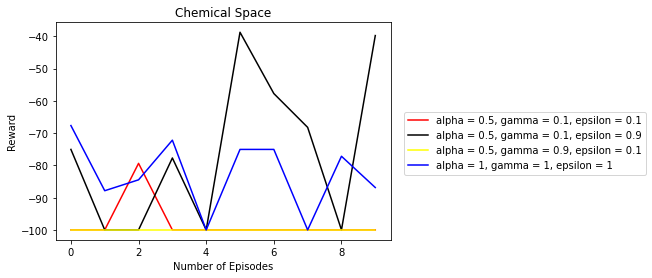

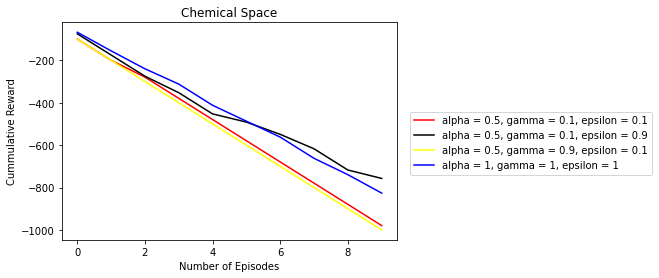

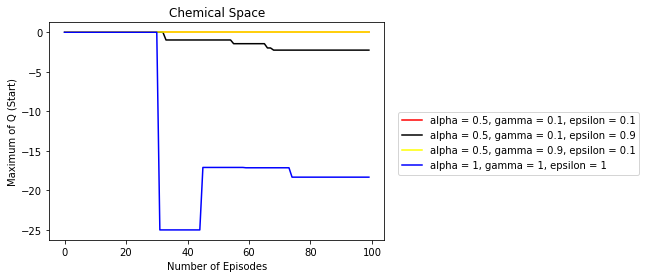

In [26]:
episodes = 100
test_episodes = np.arange(0,10,1)
#max_Q = np.zeros(len(episodes), dtype=float)

alpha = [0.5,0.5,0.5,1]
gamma = [0.1,0.1,0.9,1]
epsilon = [0.1,0.9,0.1,1]

random_color=['red', 'black', 'yellow', 'blue']

fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
fig3,ax3 = plt.subplots()
#ax1.figure(figsize=(8, 6), dpi=80)
#ax2.figure(figsize=(8, 6), dpi=80)
for m in range(len(alpha)):
    reward = []
    cumm_reward = []
    max_Q = []
    tot_reward = 0
    
    # Reset Database
    ligand_rewards = {}
    ligand_hash = {}
    reset_ligand_data()
    
    # Initialize the Q-matrix with zeros
    Q = np.zeros((len(ligand_rewards),len(molecule_list)))

    # Train the agent for the specified number of episodes
    for j in range(episodes):
        _, _, Q, _ = run_episodev1(Q, alpha[m], gamma[m], epsilon[m])
        max_Q.append(Q[0].max())
    
    ax3.plot(np.arange(0,episodes,1), max_Q, label = 'alpha = {}, gamma = {}, epsilon = {}'.format(alpha[m], gamma[m], epsilon[m]), color=random_color[m])
    
    # Test agent and evaluate performance
    for j in range(len(test_episodes)):
        R, _, Q, _ = run_episodev1(Q, alpha[m], gamma[m], epsilon[m], training = False)
        reward.append(R)
        tot_reward += R
        cumm_reward.append(tot_reward)
        
    ax1.plot(test_episodes, reward, label = 'alpha = {}, gamma = {}, epsilon = {}'.format(alpha[m], gamma[m], epsilon[m]), color=random_color[m])
    ax2.plot(test_episodes, cumm_reward, label = 'alpha = {}, gamma = {}, epsilon = {}'.format(alpha[m], gamma[m], epsilon[m]), color=random_color[m])

ax1.legend(loc=(1.04,0.3))
ax2.legend(loc=(1.04,0.3))
ax3.legend(loc=(1.04,0.3))
ax1.set_title('Chemical Space')
ax1.set_xlabel('Number of Episodes')
ax1.set_ylabel('Reward')
ax2.set_title('Chemical Space')
ax2.set_xlabel('Number of Episodes')
ax2.set_ylabel('Cummulative Reward')
ax3.set_title('Chemical Space')
ax3.set_xlabel('Number of Episodes')
ax3.set_ylabel('Maximum of Q (Start)')
plt.show()

## Algorithm 2

Adding new states to one policy N+1 in Q matrix

In [9]:
# Define a function to simulate an episode
def run_episodev2(alpha, gamma, epsilon, training=True):
    
    # Initialize start state
    state = ligand_hash.get(0)
    
    # Choose the first action using an epsilon-greedy policy
    action = choose_action(Q, state, epsilon)
    
    # Initialize the total reward
    total_reward = 0
    reward = 0
    
    #Initialize to count hashcodes found for each episode
    hits = 0
        
    for i in range(4):
        # Move to the next state
        dim = np.random.randint(0, 4)
        next_ligand = state.copy()
        next_ligand[dim] = action
        next_state = get_hash(next_ligand)
        
        # If state not found in database, then point next state to last state in Q matrix (extra state)
        if next_state == -1:
            reward = -25
            next_state = len(Q) - 1
        else:
            reward = ligand_rewards[next_state]
            hits += 1
        
        # Get next action
        next_action = choose_action(Q, next_state, epsilon)
        if training == True:
            # Update the Q-value using SARSA
            update_q_value(Q, get_hash(state), action, reward, next_state, next_action, alpha, gamma, False)

        # Update the total reward and current state and action
        total_reward += reward
        state = next_ligand
        action = next_action
        
    return total_reward, state, hits

In [10]:
# Train the agent for the specified number of episodes
alpha = 0.5
gamma = 0.9
epsilon = 1
no_of_episodes = 10

#[11,2,13,10]
#[11,8,9,6]

# Initialize the Q-matrix with zeros
Q = np.zeros((len(ligand_rewards)+1,len(molecule_list)+1))

for i in range(no_of_episodes):
    total_reward, state, hits = run_episodev2(alpha, gamma, epsilon)
    print(f"Episode {i} : Total Reward = {total_reward}, Final State = {state}, Hashcode found = {hits}")

Episode 0 : Total Reward = -82.380331, Final State = [2, 5, 6, 6], Hashcode found = 1
Episode 1 : Total Reward = -100, Final State = [5, 13, 0, 9], Hashcode found = 0
Episode 2 : Total Reward = -100, Final State = [1, 12, 3, 1], Hashcode found = 0
Episode 3 : Total Reward = -49.188064000000004, Final State = [6, 5, 1, 3], Hashcode found = 2
Episode 4 : Total Reward = -100, Final State = [1, 11, 1, 0], Hashcode found = 0
Episode 5 : Total Reward = -100, Final State = [1, 1, 4, 5], Hashcode found = 0
Episode 6 : Total Reward = -58.227062000000004, Final State = [7, 4, 1, 6], Hashcode found = 2
Episode 7 : Total Reward = -100, Final State = [13, 10, 1, 1], Hashcode found = 0
Episode 8 : Total Reward = -51.885220000000004, Final State = [2, 3, 11, 1], Hashcode found = 2
Episode 9 : Total Reward = -100, Final State = [1, 10, 1, 4], Hashcode found = 0


In [11]:
# Test the agent
for i in range(10):
    total_reward, state, hits = run_episodev2(alpha, gamma, epsilon, training=False)
    print(f"Episode {i} : Total Reward = {total_reward}, Final State = {state}, Hashcode Found = {hits}")

Episode 0 : Total Reward = -100, Final State = [1, 8, 10, 0], Hashcode Found = 0
Episode 1 : Total Reward = -100, Final State = [9, 1, 1, 4], Hashcode Found = 0
Episode 2 : Total Reward = -100, Final State = [2, 12, 12, 1], Hashcode Found = 0
Episode 3 : Total Reward = -71.738997, Final State = [5, 2, 2, 1], Hashcode Found = 1
Episode 4 : Total Reward = -65.21719, Final State = [1, 1, 5, 13], Hashcode Found = 1
Episode 5 : Total Reward = -85.535074, Final State = [3, 2, 1, 11], Hashcode Found = 1
Episode 6 : Total Reward = -62.451339000000004, Final State = [13, 8, 7, 7], Hashcode Found = 1
Episode 7 : Total Reward = -100, Final State = [10, 10, 9, 2], Hashcode Found = 0
Episode 8 : Total Reward = -100, Final State = [8, 0, 13, 1], Hashcode Found = 0
Episode 9 : Total Reward = -100, Final State = [1, 1, 12, 11], Hashcode Found = 0


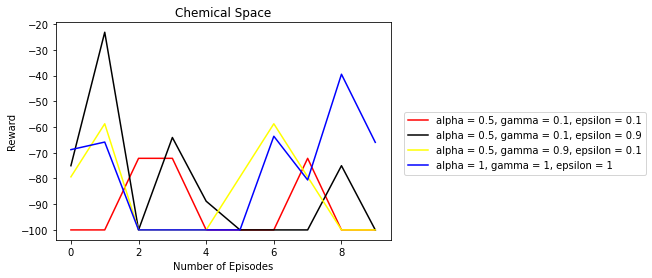

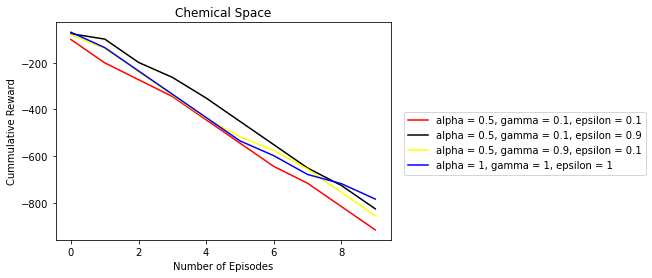

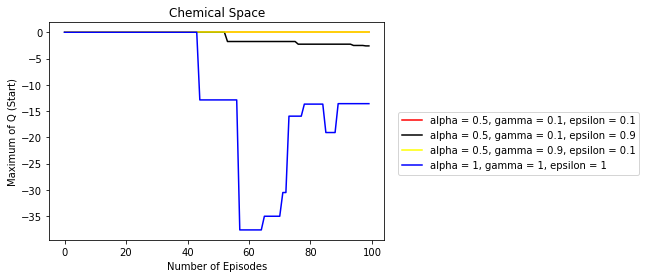

In [12]:
episodes = 100
test_episodes = np.arange(0,10,1)
#max_Q = np.zeros(len(episodes), dtype=float)

alpha = [0.5,0.5,0.5,1]
gamma = [0.1,0.1,0.9,1]
epsilon = [0.1,0.9,0.1,1]

random_color=['red', 'black', 'yellow', 'blue']

fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
fig3,ax3 = plt.subplots()
#ax1.figure(figsize=(8, 6), dpi=80)
#ax2.figure(figsize=(8, 6), dpi=80)
for m in range(len(alpha)):
    reward = []
    cumm_reward = []
    max_Q = []
    tot_reward = 0
    
    # Initialize the Q-matrix with zeros
    Q = np.zeros((len(ligand_rewards),len(molecule_list)))

    # Train the agent for the specified number of episodes
    for j in range(episodes):
        _, _, _ = run_episodev2(alpha[m], gamma[m], epsilon[m])
        max_Q.append(Q[0].max())
    
    ax3.plot(np.arange(0,episodes,1), max_Q, label = 'alpha = {}, gamma = {}, epsilon = {}'.format(alpha[m], gamma[m], epsilon[m]), color=random_color[m])
    
    # Test agent and evaluate performance
    for j in range(len(test_episodes)):
        R, _, _ = run_episodev2(alpha[m], gamma[m], epsilon[m], training = False)
        reward.append(R)
        tot_reward += R
        cumm_reward.append(tot_reward)
        
    ax1.plot(test_episodes, reward, label = 'alpha = {}, gamma = {}, epsilon = {}'.format(alpha[m], gamma[m], epsilon[m]), color=random_color[m])
    ax2.plot(test_episodes, cumm_reward, label = 'alpha = {}, gamma = {}, epsilon = {}'.format(alpha[m], gamma[m], epsilon[m]), color=random_color[m])

ax1.legend(loc=(1.04,0.3))
ax2.legend(loc=(1.04,0.3))
ax3.legend(loc=(1.04,0.3))
ax1.set_title('Chemical Space')
ax1.set_xlabel('Number of Episodes')
ax1.set_ylabel('Reward')
ax2.set_title('Chemical Space')
ax2.set_xlabel('Number of Episodes')
ax2.set_ylabel('Cummulative Reward')
ax3.set_title('Chemical Space')
ax3.set_xlabel('Number of Episodes')
ax3.set_ylabel('Maximum of Q (Start)')
plt.show()

## Algorithm 3

N-step algorithm for SARSA to solve the chemical space problem

In [29]:
# Define a function to simulate an episode
def run_episode_n_step(alpha, gamma, epsilon, n, training=True):
    
    total_reward = 0
    #Initialize to count hashcodes found for each episode
    hits = 0
    
    for k in range(4):
    
        t = 0
        T = np.inf

        # Initialize start state
        state = ligand_hash.get(0)

        # Choose the first action using an epsilon-greedy policy
        action = choose_action(Q, state, epsilon)

        # Initialize variables
        reward = 0
        rewards = [0]
        states = [0]
        actions = [action]

        while True:
            if t < T:
               # Move to the next state
                dim = np.random.randint(0, 4)
                next_ligand = state.copy()
                next_ligand[dim] = action
                next_state = get_hash(next_ligand) 

                # Get reward
                # If state not found in database, then point next state to last state in Q matrix (extra state)
                if next_state == -1:
                    reward = -25
                    next_state = len(Q) - 1
                else:
                    reward = ligand_rewards[next_state]
                    hits += 1

                states.append(next_state)
                rewards.append(reward)

                if next_state > -1:
                    T = t + 1
                else:
                    # Get next action
                    action = choose_action(Q, next_state, epsilon)
                    actions.append(action)

            # state tau being updated
            tau = t - n + 1

            if tau >= 0:
                G = 0
                for i in range(tau + 1, min(tau + n + 1, T + 1)):
                    G += np.power(gamma, i - tau - 1) * rewards[i]
                if tau + n < T:
                    state_action = (states[tau + n], actions[tau + n])
                    G += np.power(gamma, n) * Q[state_action[0]][state_action[1]]
                # update Q values
                state_action = (states[tau], actions[tau])
                Q[state_action[0]][state_action[1]] += alpha * (G - Q[state_action[0]][state_action[1]])

            if tau == T - 1:
                #print(t)
                break

            t += 1

            # Update the total reward and current state and action
            total_reward += reward
            state = next_ligand
            #action = next_action
        
    return total_reward, state, hits

In [34]:
# Train the agent for the specified number of episodes
alpha = 0.5
gamma = 0.9
epsilon = 1
no_of_episodes = 20

#[11,2,13,10]
#[11,8,9,6]

# Initialize the Q-matrix with zeros
Q = np.zeros((len(ligand_rewards)+1,len(molecule_list)+1))

for i in range(no_of_episodes):
    total_reward, state, hits = run_episode_n_step(alpha, gamma, epsilon, n=5)
    print(f"Episode {i} : Total Reward = {total_reward}, Final State = {state}, Hashcode found = {hits}")

Episode 0 : Total Reward = -400, Final State = [11, 1, 1, 1], Hashcode found = 4
Episode 1 : Total Reward = -400, Final State = [1, 1, 6, 1], Hashcode found = 4
Episode 2 : Total Reward = -400, Final State = [1, 6, 1, 1], Hashcode found = 4
Episode 3 : Total Reward = -400, Final State = [7, 1, 1, 1], Hashcode found = 4
Episode 4 : Total Reward = -400, Final State = [3, 1, 1, 1], Hashcode found = 4
Episode 5 : Total Reward = -300.16856800000005, Final State = [1, 12, 1, 1], Hashcode found = 4
Episode 6 : Total Reward = -300.168568, Final State = [1, 1, 2, 1], Hashcode found = 4
Episode 7 : Total Reward = -300.16856800000005, Final State = [1, 1, 1, 1], Hashcode found = 4
Episode 8 : Total Reward = -400, Final State = [1, 1, 4, 1], Hashcode found = 4
Episode 9 : Total Reward = -400, Final State = [1, 1, 9, 1], Hashcode found = 4
Episode 10 : Total Reward = -400, Final State = [1, 9, 1, 1], Hashcode found = 4
Episode 11 : Total Reward = -400, Final State = [1, 1, 1, 5], Hashcode found = 4

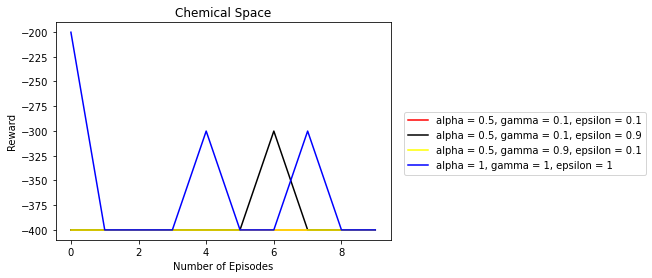

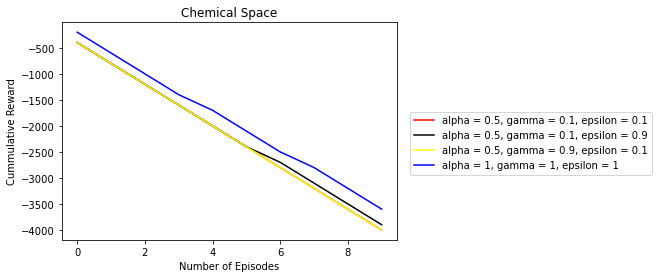

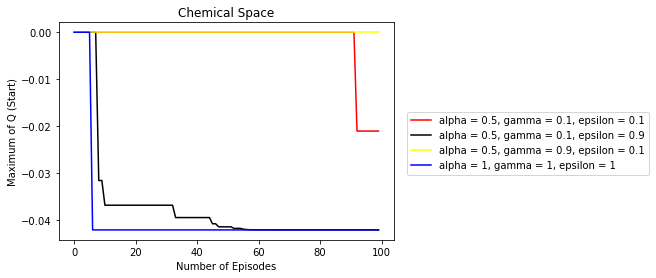

In [37]:
episodes = 100
test_episodes = np.arange(0,10,1)
n_step = 5
#max_Q = np.zeros(len(episodes), dtype=float)

alpha = [0.5,0.5,0.5,1]
gamma = [0.1,0.1,0.9,1]
epsilon = [0.1,0.9,0.1,1]

random_color=['red', 'black', 'yellow', 'blue']

fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
fig3,ax3 = plt.subplots()
#ax1.figure(figsize=(8, 6), dpi=80)
#ax2.figure(figsize=(8, 6), dpi=80)
for m in range(len(alpha)):
    reward = []
    cumm_reward = []
    max_Q = []
    tot_reward = 0
    
    # Initialize the Q-matrix with zeros
    Q = np.zeros((len(ligand_rewards),len(molecule_list)))

    # Train the agent for the specified number of episodes
    for j in range(episodes):
        _, _, _ = run_episode_n_step(alpha[m], gamma[m], epsilon[m], n_step)
        max_Q.append(Q[0].max())
    
    ax3.plot(np.arange(0,episodes,1), max_Q, label = 'alpha = {}, gamma = {}, epsilon = {}'.format(alpha[m], gamma[m], epsilon[m]), color=random_color[m])
    
    # Test agent and evaluate performance
    for j in range(len(test_episodes)):
        R, _, _ = run_episode_n_step(alpha[m], gamma[m], epsilon[m], n_step, training = False)
        reward.append(R)
        tot_reward += R
        cumm_reward.append(tot_reward)
        
    ax1.plot(test_episodes, reward, label = 'alpha = {}, gamma = {}, epsilon = {}'.format(alpha[m], gamma[m], epsilon[m]), color=random_color[m])
    ax2.plot(test_episodes, cumm_reward, label = 'alpha = {}, gamma = {}, epsilon = {}'.format(alpha[m], gamma[m], epsilon[m]), color=random_color[m])

ax1.legend(loc=(1.04,0.3))
ax2.legend(loc=(1.04,0.3))
ax3.legend(loc=(1.04,0.3))
ax1.set_title('Chemical Space')
ax1.set_xlabel('Number of Episodes')
ax1.set_ylabel('Reward')
ax2.set_title('Chemical Space')
ax2.set_xlabel('Number of Episodes')
ax2.set_ylabel('Cummulative Reward')
ax3.set_title('Chemical Space')
ax3.set_xlabel('Number of Episodes')
ax3.set_ylabel('Maximum of Q (Start)')
plt.show()